# Exercício 4 – Placa com Força de Corpo Específica (DeepXDE)

Implementação de um PINN com a biblioteca **DeepXDE** para resolver o problema de elasticidade no plano bidimensional com forças de corpo específicas, conforme enunciado da Figura 4.

- 📏 Geometria: Placa quadrada unitária (1 x 1)
- 🧮 Condições de contorno: conforme a imagem do enunciado
- 📌 Biblioteca utilizada: DeepXDE


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import torch


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## 1. Domínio e condições de contorno

- Domínio: quadrado unitário [0,1] x [0,1]
- Condições de contorno (Dirichlet):
  - \( u_x = 0 \) em \( x = 0 \) e \( x = 1 \)
  - \( u_y = 0 \) em \( y = 0 \) e \( y = 1 \)
  - Exceto na parte superior, onde \( \sigma_{xy} = 2e^{x}(4 + 2x)(x - x^2) \)


In [2]:
# Domínio: quadrado unitário
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Condições de contorno para ux e uy
def bc_x(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0) or np.isclose(x[0], 1))

def bc_y(x, on_boundary):
    return on_boundary and (np.isclose(x[1], 0) or np.isclose(x[1], 1))

bc1 = dde.DirichletBC(geom, lambda x: 0, bc_x, component=0)  # ux
bc2 = dde.DirichletBC(geom, lambda x: 0, bc_y, component=1)  # uy


## 2. Forças de corpo e equações

Conforme enunciado, as forças de corpo \( f_x \) e \( f_y \) são:

\[
\begin{aligned}
f_x &= -2Q \pi y (1 - 2x) e^x + \mu \left[ (-2Qy(1 - 2x)e^x + \pi^2 \sin(\pi y)) \right] \\
f_y &= \lambda(-4Qy^2(-x^2 + x)e^x - 2Q(-x^2 + x)e^x) \\
&\quad + \mu(-8Qy^2(-x^2 + x)e^x - 4Q(-x^2 + x)e^x + 2Qe^x)
\end{aligned}
\]


In [3]:
# Constantes
Q = 1.0
mu = 1.0
lmbda = 1.0
pi = np.pi

# Equações de elasticidade com forças de corpo
def pde(x, y):
    u, v = y[:, 0:1], y[:, 1:2]
    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    u_y = dde.grad.jacobian(y, x, i=0, j=1)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)
    v_y = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    v_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # Usando torch em vez de numpy
    fx = -2 * Q * pi * x[:, 1:2] * (1 - 2 * x[:, 0:1]) * torch.exp(x[:, 0:1]) + \
         mu * (-2 * Q * x[:, 1:2] * (1 - 2 * x[:, 0:1]) * torch.exp(x[:, 0:1]) + pi ** 2 * torch.sin(pi * x[:, 1:2]))

    fy = lmbda * (-4 * Q * x[:, 1:2]**2 * (-x[:, 0:1]**2 + x[:, 0:1]) * torch.exp(x[:, 0:1]) \
         - 2 * Q * (-x[:, 0:1]**2 + x[:, 0:1]) * torch.exp(x[:, 0:1])) + \
         mu * (-8 * Q * x[:, 1:2]**2 * (-x[:, 0:1]**2 + x[:, 0:1]) * torch.exp(x[:, 0:1]) \
         - 4 * Q * (-x[:, 0:1]**2 + x[:, 0:1]) * torch.exp(x[:, 0:1]) + 2 * Q * torch.exp(x[:, 0:1]))

    eq1 = mu * (u_xx + u_yy) + (lmbda + mu) * (u_x + v_y) - fx
    eq2 = mu * (v_xx + v_yy) + (lmbda + mu) * (u_x + v_y) - fy

    return [eq1, eq2]


## 3. Rede Neural, Treinamento e Visualização

A seguir, definimos a arquitetura da rede, treinamos o PINN e comparamos com a solução analítica:
- \( u_x = \sin(\pi y) \)
- \( u_y = Q e^x (x - x^2) \)


In [4]:
# Dados do problema
data = dde.data.PDE(
    geom, pde, [bc1, bc2],
    num_domain=5000,
    num_boundary=1000,
    solution=None
)

# Arquitetura da rede
net = dde.maps.FNN([2] + [50] * 3 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# (Opcional: usar BFGS depois)
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 4.358485 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e+02, 5.48e+00, 2.86e-02, 2.01e-01]    [1.01e+02, 5.48e+00, 2.86e-02, 2.01e-01]    []  
1000      [1.66e-02, 1.12e-02, 7.81e-02, 1.08e-02]    [1.66e-02, 1.12e-02, 7.81e-02, 1.08e-02]    []  
2000      [5.39e-03, 2.42e-03, 3.57e-02, 1.29e-03]    [5.39e-03, 2.42e-03, 3.57e-02, 1.29e-03]    []  
3000      [3.35e-03, 1.11e-03, 2.26e-02, 7.66e-04]    [3.35e-03, 1.11e-03, 2.26e-02, 7.66e-04]    []  
4000      [2.10e-02, 8.15e-03, 1.38e-02, 4.40e-04]    [2.10e-02, 8.15e-03, 1.38e-02, 4.40e-04]    []  
5000      [5.47e-03, 2.09e-03, 7.22e-03, 4.39e-04]    [5.47e-03, 2.09e-03, 7.22e-03, 4.39e-04]    []  

Best model at step 5000:
  train loss: 1.52e-02
  test loss: 1.52e-02
  test metric: []

'train' took 325.640774 s

Compiling model...
'compile' took 0.000415 s

Training model...

Step      Train loss     

(<deepxde.model.LossHistory at 0x2c9ff9a31a0>,
 <deepxde.model.TrainState at 0x2c9bc930c80>)

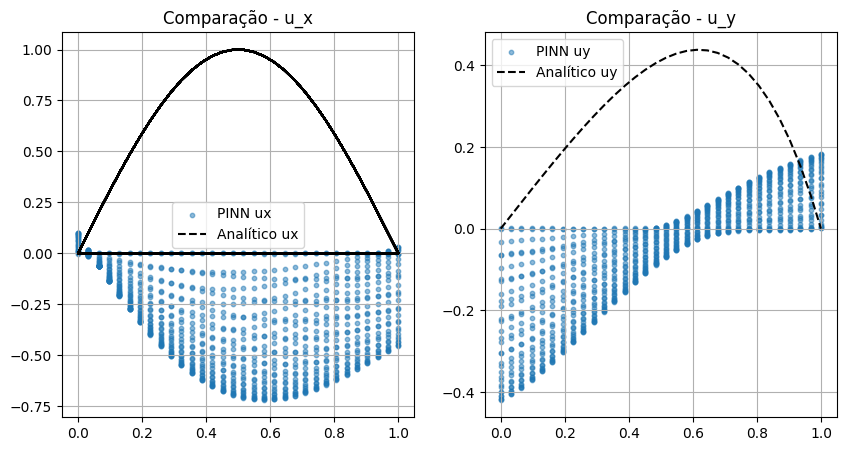

In [5]:
# Pontos de teste
X = geom.uniform_points(1000, True)
y_pred = model.predict(X)

# Soluções analíticas
ux_analitico = np.sin(np.pi * X[:, 1:2])
uy_analitico = Q * np.exp(X[:, 0:1]) * (X[:, 0:1] - X[:, 0:1]**2)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X[:, 1], y_pred[:, 0], s=10, label="PINN ux", alpha=0.5)
plt.plot(X[:, 1], ux_analitico, 'k--', label="Analítico ux")
plt.title("Comparação - u_x")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X[:, 0], y_pred[:, 1], s=10, label="PINN uy", alpha=0.5)
plt.plot(X[:, 0], uy_analitico, 'k--', label="Analítico uy")
plt.title("Comparação - u_y")
plt.legend()
plt.grid()


# Salvar imagem
plt.savefig('../imagens/Placa_ForcaCorpo_PINN.png')
plt.show()
